In [ ]:
%matplotlib inline 
#Used for plotting graph 
import pandas as pd
import numpy as np

import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding,LSTM,Dropout
from sklearn.metrics.classification import accuracy_score, log_loss
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint




Checking GPU Alloted

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Run This Cell For Adding Reference of Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Training Data Variants


In [ ]:
data_variants = pd.read_csv('/content/drive/MyDrive/mskdata/training_variants')
data_variants.head()  


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


Unique Top 20 Genes

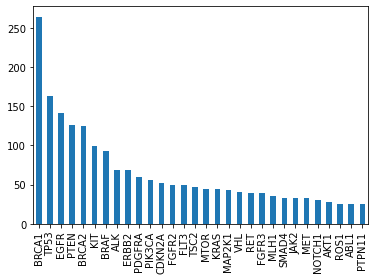

In [ ]:
unique_genes_distribution = data_variants['Gene'].value_counts()
unique_genes_distribution.head(30).plot(kind = 'bar')

#print(unique_genes_distribution.head(40))


In [ ]:
data_variants.isnull().sum()
#Cheking If data_variants contains Null Values

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

Training Text Data

In [ ]:
data_text =pd.read_csv("/content/drive/MyDrive/mskdata/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
data_text.head()


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [ ]:
data_text.isnull().sum()


ID      0
TEXT    5
dtype: int64

In [ ]:
data_text.dropna(axis=0,how='any',inplace=True)
data_text.isnull().sum()


ID      0
TEXT    0
dtype: int64

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
sw = set(stopwords.words('english'))
def nlp_preprocessing(totaltext,row,col):
    if type(totaltext) is not int:
        string = ""
        #Replace special characters with space
        totaltext = re.sub('[^a-zA-Z0-9\n]',' ',totaltext)

         #Replace multiple tab with single space
        totaltext = re.sub('\s+',' ',totaltext)

        #lower-case all the characters
        totaltext= totaltext.lower()
       
        for word in totaltext.split():
            # if the word is a not a stop word then retain that word from the data
            if not word in sw:
                string += word+' '
                
        data_text[col][row] = string
        
        
      

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Calling nlp_preprocessing method created above for Preprocessing

In [ ]:
import time
import re

for index, row in data_text.iterrows():
    nlp_preprocessing(row['TEXT'], index, 'TEXT')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
dataframe_train = pd.merge(data_variants,data_text,on= 'ID',how = 'left')
dataframe_train.head()



,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [ ]:
dataframe_train['full_text'] = dataframe_train[['Gene','Variation']].apply(lambda x: ' '.join(x),axis=1)


In [ ]:
dataframe_train['TEXT'] = dataframe_train['TEXT'].astype(str)



In [ ]:
dataframe_train['full_text'] = dataframe_train[['full_text','TEXT']].apply(lambda x: ' '.join(x),axis=1)


In [ ]:
dataframe_train.head()



,ID,Gene,Variation,Class,TEXT,full_text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...,FAM58A Truncating Mutations cyclin dependent k...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...,CBL W802* abstract background non small cell l...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...,CBL Q249E abstract background non small cell l...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...,CBL N454D recent evidence demonstrated acquire...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...,CBL L399V oncogenic mutations monomeric casita...


Distribution Of Different Classes in Used Data

In [ ]:
class_distribution = dataframe_train['Class'].value_counts()
class_distribution

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

Tokenization

In [ ]:
# Use the Keras tokenizer
voc_size = 10000
tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(dataframe_train['full_text'].values)


Padding

In [ ]:
X = tokenizer.texts_to_sequences(dataframe_train['full_text'].values)
X = pad_sequences(X, maxlen=voc_size)


# Model 

In [ ]:
embed_dimension = 16
lstm_out_shape = 166

ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model = Sequential()
model.add(Embedding(voc_size, embed_dimension, input_length = X.shape[1]))

model.add(LSTM(lstm_out_shape,return_sequences=True,recurrent_dropout=0, dropout=0))
model.add(LSTM(lstm_out_shape,recurrent_dropout=0,dropout=0))
model.add(Dense(9,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10000, 16)         160000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 10000, 166)        121512    
_________________________________________________________________
lstm_9 (LSTM)                (None, 166)               221112    
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 1503      
Total params: 504,127
Trainable params: 504,127
Non-trainable params: 0
_________________________________________________________________
None


Execute this Code to Mount Drive for add reference to the data.

Execution Of The Model over 5 folds

In [ ]:

Y=dataframe_train['Class']
#Y
from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import StratifiedK
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lstm_test_stratified=[]
lstm_train_stratified=[]
for train_index, test_index in skf.split(X, Y):
    x_train_fold, x_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = Y[train_index], Y[test_index]
    #print(y_train_fold)
    #print(x_train_fold)
    y_train_dummy = pd.get_dummies(y_train_fold).values
    y_test_dummy = pd.get_dummies(y_test_fold).values
    lstm_train_stratified.append(model.fit(x_train_fold, y_train_dummy))
    lstm_test_stratified.append(model.evaluate(x_test_fold,y_test_dummy))

21/21 [==============================] - 7s 315ms/step - loss: 0.4108 - accuracy: 0.8208


Storing the Accuracy And Losses in Respective Array for Training and Testing

In [ ]:
print(lstm_test_stratified)
accuracy_test=[]
accuracy_train=[]
loss_test=[]
loss_train=[]

for x in lstm_test_stratified:
  loss_test.append(x[0])
  accuracy_test.append(x[1])

for x in lstm_train_stratified:
  accuracy_train.append(x.history['accuracy'])
  loss_train.append(x.history['loss'])

[[0.44746699929237366, 0.8015037775039673], [0.44033709168434143, 0.8117470145225525], [0.43352845311164856, 0.8012048006057739], [0.43207526206970215, 0.7876505851745605], [0.4108198285102844, 0.8207831382751465]]


In [ ]:
#Predicting Testing Data 
probas = model.predict(x_test_fold)


In [ ]:
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]
print('Test Log loss: {}'.format(log_loss(classes[np.argmax(y_test_dummy, axis=1)], probas)))
print('Test Accuracy: {}'.format(accuracy_score(classes[np.argmax(y_test_dummy, axis=1)], preds)))

Test Log loss: 0.41081979560594956
Test Accuracy: 0.8207831325301205


Confusion Matrix  (Precision)



In [ ]:
#Precision =True Positive/Sum of Column
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sborn
def plot_precision_matrix(test_y, predict_y):
    Col = confusion_matrix(test_y, predict_y)
    A =(((Col.T)/(Col.sum(axis=1))).T)
    B =(Col/Col.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]
    print("."*40, "Precision matrix", "."*40)
    plt.figure(figsize=(20,7))
    sborn.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    

(664, 9)
-------------------- Precision matrix --------------------


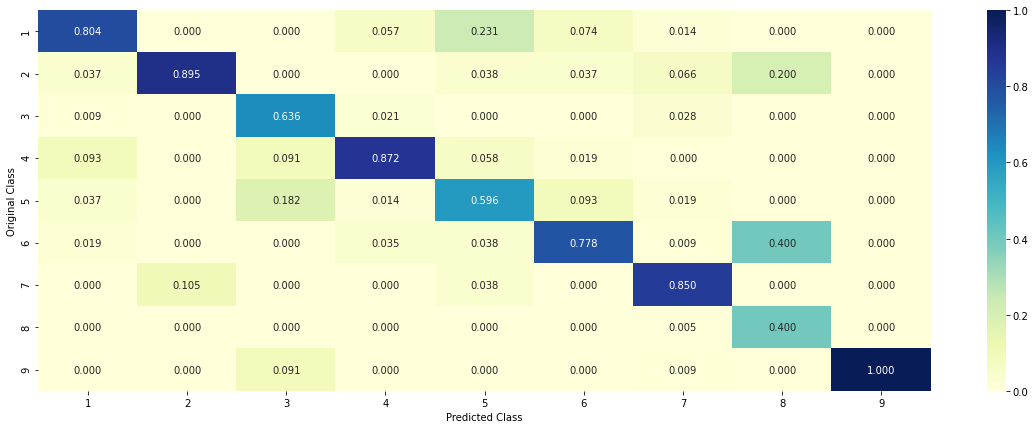

In [ ]:
print(y_test_dummy.shape)
#print(y_test_dummy)

plot_precision_matrix(classes[np.argmax(y_test_dummy, axis=1)], preds)



In [ ]:

probas_train = model.predict(x_train_fold)
    

In [ ]:
pred_indices_train = np.argmax(probas_train, axis=1)
classes = np.array(range(1, 10))
preds_train = classes[pred_indices_train]
print('Train Log loss: {}'.format(log_loss(classes[np.argmax(y_train_dummy, axis=1)], probas_train)))
print('Train Accuracy: {}'.format(accuracy_score(classes[np.argmax(y_train_dummy, axis=1)], preds_train)))


Train Log loss: 0.39876324112418765
Train Accuracy: 0.8178396687993978


-------------------- Precision matrix --------------------


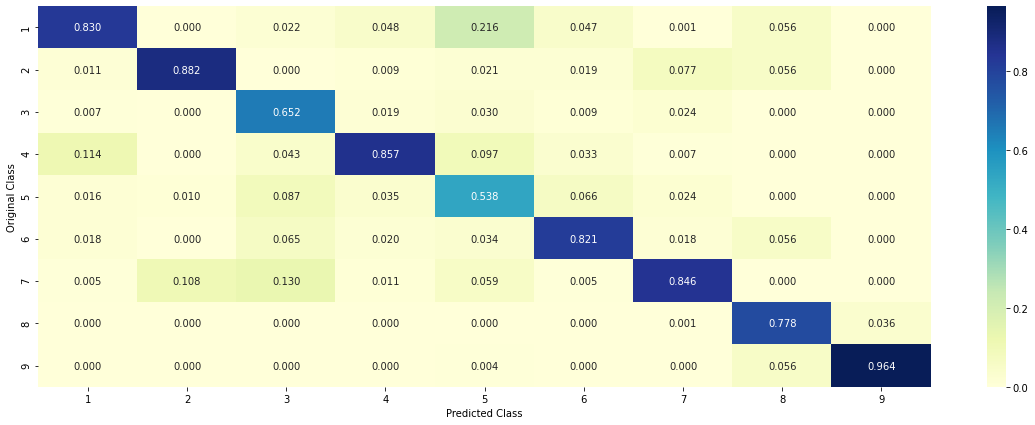

(2657, 9)


In [ ]:
plot_precision_matrix(classes[np.argmax(y_train_dummy, axis=1)], preds_train)
print(y_train_dummy.shape)